<div style="text-align: right"> <b>Release Date:</b> 16.09.2023 </div>

<div style="text-align: right"> v.1.0.0 </div>

---

<h3><center> FeVAcS: FEniCS Visualizing Acoustic Scattering </center></h3>
<h4><center> Öğüç, M.<sup>1</sup>, Okyar, A.F.<sup>2</sup>, Khajah, T.<sup>3</sup></center></h4>
<t4><center> <sup>1</sup>İstanbul Atlas University, Biomedical Eng. Dept.</center></t4>
<t4><center> <sup>2</sup>Yeditepe University, Mech. Eng. Dept. </center></t4>
<t4><center> <sup>3</sup>The University of Texas at Tyler, Mech. Eng. Dept. </center></t4>

---
This notebook solves acoustic scattering of perfectly symmetric circular cylinders with a 1D periodic arrangement with FEniCS in a 2-D rectangular domain using homogeneous Neumann boundary conditions (HNBCs) and periodic boundary conditions (PBCs).

#### Libraries

In [1]:
from fenics import *
from mshr import *
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#### Input Parameters

In [2]:
# Discretization density
n_lambda = 50
# Angular wavenumber
k = 2*np.pi
# Function-space order
p = 3
# Expression-degree
q = 4

# Domain parameters
xmin = -2
xmax = -xmin
ymin = -2
ymax = -ymin

# Circular cylinder dimensions
xcyl_1 = 0
ycyl_1 = 0
r_1 = 1

# Number of mesh points to calculate the gridsize
N = int(round((n_lambda*(xmax-xcyl_1)*k/(2*np.pi))/xmax,0))

# Tolerance for marking the boundaries
tol = 0.01

# Global fontsize for plots
fsize = 14
plt.rcParams['xtick.labelsize']=fsize
plt.rcParams['ytick.labelsize']=fsize

#### Mesh Generation

In [3]:
def Mesh_Cylinder(xmin, xmax, ymin, ymax, xcyl_1, ycyl_1, r_1, n_lambda, k):

    # Create the solution domain
    domain_rectangle = Rectangle(Point(xmin, ymin), Point(xmax, ymax))
    
    n_x = int(n_lambda*(xmax-xcyl_1)*k/(2*np.pi))
    n_tangential = int(n_x*2*np.pi)
    
    # Single cylinder shaped obstacle
    cylinder_1  = Circle(Point(xcyl_1, ycyl_1), r_1, n_tangential)
    
    domain = domain_rectangle - cylinder_1
    mesh = generate_mesh(domain, int(n_x*2))
    
    return mesh

In [4]:
mesh = Mesh_Cylinder(xmin, xmax, ymin, ymax, xcyl_1, ycyl_1, r_1, n_lambda, k)

Text(0, 0.5, '$y$')

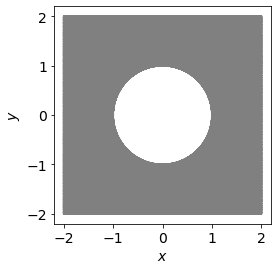

In [5]:
plot(mesh)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)

#### Extract Mesh Data

In [6]:
FS = FunctionSpace(mesh, 'P', p)

n_1 = FS.dim()
d_1 = mesh.geometry().dim()

FS_dof_coordinates = FS.tabulate_dof_coordinates()
FS_dof_coordinates.resize((n_1, d_1))
FS_dof_x = FS_dof_coordinates[:, 0]
FS_dof_y = FS_dof_coordinates[:, 1]

print("DOF of Function-space FS:", FS.dim())

DOF of Function-space FS: 449715


#### Plane Wave

In [7]:
def Plane_Wave(k, x):
    
    u_inc = np.cos(k*x) + 1j*np.sin(k*x)
    
    return u_inc

In [8]:
FS_PW_temp = Plane_Wave(k, FS_dof_x)
FS_PW_temp_r = FS_PW_temp.real
FS_PW_temp_i = FS_PW_temp.imag

u_p_r = Function(FS)
u_p_i = Function(FS)

u_p_r.vector().set_local(FS_PW_temp_r)
u_p_i.vector().set_local(FS_PW_temp_i)

#### FEM

Model 1: Homogeneos Neumann BC is used on the upper and lower boundaries.

In [9]:
def Helmholtz_1(mesh, k, xmin, xmax, ymin, ymax, xcyl_1, ycyl_1, r_1, p, q, tol):
       
    Er = FiniteElement('P', triangle, p)
    Ei = FiniteElement('P', triangle, p)
    Ec = Er * Ei
    V = FunctionSpace(mesh,Ec)
    print("DOF of Functions-space V:", round(V.dim()/2))
          
    # Define boundary subdomains
    
    boundary_markers = MeshFunction("size_t",mesh, mesh.topology().dim()-1)
    
    class BoundaryL(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], xmin, tol)
    
    class BoundaryR(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], xmax, tol)
    
    class BoundaryS(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and sqrt(pow(xcyl_1 - x[0],2) + pow(ycyl_1 - x[1],2)) <= r_1 + tol

    bc_L = BoundaryL()
    bc_R = BoundaryR()
    bc_S = BoundaryS()

    boundary_markers.set_all(0)
    bc_L.mark(boundary_markers, 1)
    bc_R.mark(boundary_markers, 2)
    bc_S.mark(boundary_markers, 3)
    
    C_1 = Expression('k*cos(atan2(ycyl_1 + x[1],x[0] - xcyl_1))*cos(k*(x[0] - xcyl_1))',degree=q, k=k, xcyl_1 = xcyl_1, ycyl_1 = ycyl_1)
    C_2 = Expression('k*cos(atan2(ycyl_1 + x[1],x[0] - xcyl_1))*sin(k*(x[0] - xcyl_1))',degree=q, k=k, xcyl_1 = xcyl_1, ycyl_1 = ycyl_1)
    
    # Redefine boundary integration measure
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    
    # define variational problem
    (u_r, u_i) = TrialFunction(V)
    (v_r, v_i) = TestFunction(V)

    a_r = \
    + inner(nabla_grad(u_r), nabla_grad(v_r))*dx\
    - inner(nabla_grad(u_i), nabla_grad(v_i))*dx\
    - pow(k,2)*( inner(u_r,v_r) - inner(u_i,v_i))*dx\
    + k*(inner(u_r,v_i) + inner(u_i,v_r))*ds(1)\
    + k*(inner(u_r,v_i) + inner(u_i,v_r))*ds(2)

    a_i = \
    + inner(nabla_grad(u_r), nabla_grad(v_i))*dx\
    + inner(nabla_grad(u_i), nabla_grad(v_r))*dx\
    - pow(k,2)*( inner(u_r,v_i) + inner(u_i,v_r))*dx\
    - k*(inner(u_r,v_r) - inner(u_i,v_i))*ds(1)\
    - k*(inner(u_r,v_r) - inner(u_i,v_i))*ds(2)
    
    L_r = -(C_2*v_r + C_1*v_i)*ds(3)
    L_i =  (C_1*v_r - C_2*v_i)*ds(3)
    
    a = a_r + a_i
    L = L_r + L_i

    # compute solution
    u = Function(V)
    solve(a == L, u)

    return u

In [10]:
u_1_s = Helmholtz_1(mesh, k, xmin, xmax, ymin, ymax, xcyl_1, ycyl_1, r_1, p, q, tol)
(u_1_s_r, u_1_s_i) = split(u_1_s)
u_1_s_m = sqrt(pow(u_1_s_r,2) + pow(u_1_s_i,2));
u_1_m   = sqrt(pow(u_p_r + u_1_s_r,2) + pow(u_p_i + u_1_s_i,2))

DOF of Functions-space V: 449715


Model 2: Periodic BC is used on the upper and lower boundaries.

Please note that for a proper implementation of PBC, it is advisable to utilize a more precise meshing algorithm. This study was conducted to provide a rough comparison of the performance between applying homogeneous Neumann boundary conditions and implementing periodic boundary conditions. Even when the nodes along the periodic boundaries do not precisely match in coordinates, a mapping is enforced to ensure periodicity.

In [11]:
def FEM_Hard_PBC(mesh, k, xmin, xmax, ymin, ymax, xcyl_1, ycyl_1, r_1, p, q, tol):
             
    # Define boundary subdomains
    
    boundary_markers = MeshFunction("size_t",mesh, mesh.topology().dim()-1)
    
    class BoundaryL(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], xmin, tol)
    
    class BoundaryR(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], xmax, tol)
    
    class BoundaryS(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and sqrt(pow(xcyl_1 - x[0],2) + pow(ycyl_1 - x[1],2)) <= r_1 + tol

    # Sub domain for Periodic boundary condition
    class PeriodicBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return bool( ymin + tol > x[1] > ymin - tol and on_boundary)
        def map(self, x, y):
            y[0] = x[0]
            y[1] = x[1] - (ymax-ymin)
    
    bc_L = BoundaryL()
    bc_R = BoundaryR()
    bc_S = BoundaryS()

    boundary_markers.set_all(0)
    bc_L.mark(boundary_markers, 1)
    bc_R.mark(boundary_markers, 2)
    bc_S.mark(boundary_markers, 3)
    
    Er = FiniteElement('P', triangle, p)
    Ei = FiniteElement('P', triangle, p)
    Ec = Er * Ei
    V = FunctionSpace(mesh, Ec, constrained_domain=PeriodicBoundary())
    print("DOF of Functions-space V:", round(V.dim()/2))
    
    C_1 = Expression('k*cos(atan2(ycyl_1 + x[1],x[0] - xcyl_1))*cos(k*(x[0] - xcyl_1))',degree=q, k=k, xcyl_1 = xcyl_1, ycyl_1 = ycyl_1)
    C_2 = Expression('k*cos(atan2(ycyl_1 + x[1],x[0] - xcyl_1))*sin(k*(x[0] - xcyl_1))',degree=q, k=k, xcyl_1 = xcyl_1, ycyl_1 = ycyl_1)
    
    # Redefine boundary integration measure
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    
    # define variational problem
    (u_r, u_i) = TrialFunction(V)
    (v_r, v_i) = TestFunction(V)

    a_r = \
    + inner(nabla_grad(u_r), nabla_grad(v_r))*dx\
    - inner(nabla_grad(u_i), nabla_grad(v_i))*dx\
    - pow(k,2)*( inner(u_r,v_r) - inner(u_i,v_i))*dx\
    + k*(inner(u_r,v_i) + inner(u_i,v_r))*ds(1)\
    + k*(inner(u_r,v_i) + inner(u_i,v_r))*ds(2)

    a_i = \
    + inner(nabla_grad(u_r), nabla_grad(v_i))*dx\
    + inner(nabla_grad(u_i), nabla_grad(v_r))*dx\
    - pow(k,2)*( inner(u_r,v_i) + inner(u_i,v_r))*dx\
    - k*(inner(u_r,v_r) - inner(u_i,v_i))*ds(1)\
    - k*(inner(u_r,v_r) - inner(u_i,v_i))*ds(2)
    
    L_r = -(C_2*v_r + C_1*v_i)*ds(3)
    L_i =  (C_1*v_r - C_2*v_i)*ds(3)
    
    a = a_r + a_i
    L = L_r + L_i

    # compute solution
    u = Function(V)
    solve(a == L, u)

    return u

In [12]:
u_2_s = FEM_Hard_PBC(mesh, k, xmin, xmax, ymin, ymax, xcyl_1, ycyl_1, r_1, p, q, tol)
(u_2_s_r, u_2_s_i) = split(u_2_s)
u_2_s_m = sqrt(pow(u_2_s_r,2) + pow(u_2_s_i,2));
u_2_m   = sqrt(pow(u_p_r + u_2_s_r,2) + pow(u_p_i + u_2_s_i,2))

DOF of Functions-space V: 448946


#### Plots

Text(0.5, -0.5, 'Homogeneous Neumann BC with $k$=6.28, $n_{\\lambda}$=50, $p$=3')

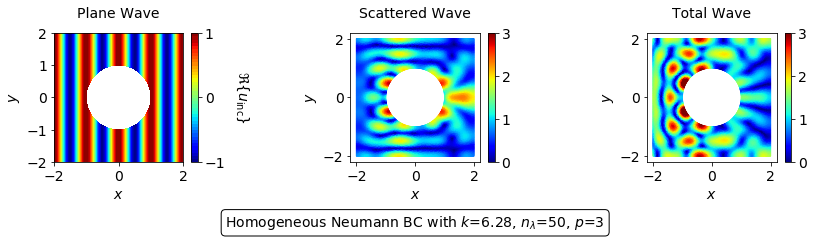

In [13]:
from matplotlib import ticker

plt.subplots(nrows=1, ncols=3, figsize=(12,3))

ax1 = plt.subplot(1, 3, 1)
fig = plot(u_p_r, cmap='jet')

plt.title('Plane Wave', pad=15, fontsize=fsize)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)
colorbar = plt.colorbar(fig, fraction=0.037, pad=0.04);
colorbar.ax.get_yaxis().labelpad = 25
colorbar.ax.set_ylabel('$\Re \{u_\mathregular{inc} \}$', rotation=270, fontsize=fsize)

tick_locator = ticker.MaxNLocator(nbins=2)
colorbar.locator = tick_locator
colorbar.update_ticks()

ax2 = plt.subplot(1, 3, 2)
color_min = 0
color_max = 3
fig = plot(u_1_s_m, cmap='jet', mode='color', vmin=color_min, vmax=color_max)

plt.title('Scattered Wave', pad=15, fontsize=fsize)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)
colorbar = plt.colorbar(fig, fraction=0.037, pad=0.04);
colorbar.ax.get_yaxis().labelpad = 25
colorbar.ax.set_ylabel('$|u_\mathregular{s}|$', rotation=270, fontsize=fsize)
colorbar.mappable.set_clim(color_min, color_max)

ax3 = plt.subplot(1, 3, 3)
color_min = 0
color_max = 3
fig = plot(u_1_m, cmap='jet', mode='color', vmin=color_min, vmax=color_max)

plt.title('Total Wave', pad=15, fontsize=fsize)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)
colorbar = plt.colorbar(fig, fraction=0.037, pad=0.04);
colorbar.ax.get_yaxis().labelpad = 25
colorbar.ax.set_ylabel('$|u|$', rotation=270, fontsize=fsize)
colorbar.mappable.set_clim(color_min, color_max)

plt.tight_layout()

ax2.text(0.5,-0.5, 'Homogeneous Neumann BC with $k$=%.2f, ' %k + r'$n_{\lambda}$=%i, ' %n_lambda + r'$p$=%i' %p,
         size=12, ha="center", transform=ax2.transAxes, fontsize=fsize,
        bbox=dict(boxstyle="round", ec='black', fc='white',))

Text(0.5, -0.5, 'Periodic BC with $k$=6.28, $n_{\\lambda}$=50, $p$=3')

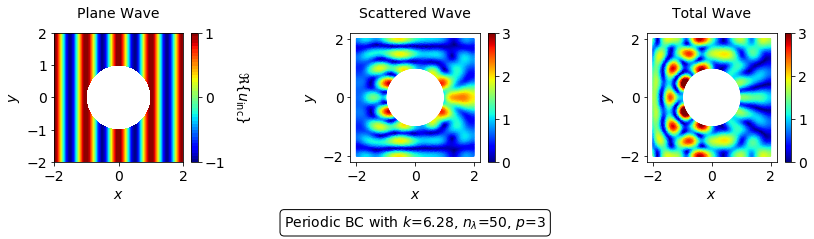

In [14]:
from matplotlib import ticker

plt.subplots(nrows=1, ncols=3, figsize=(12,3))

ax1 = plt.subplot(1, 3, 1)
fig = plot(u_p_r, cmap='jet')

plt.title('Plane Wave', pad=15, fontsize=fsize)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)
colorbar = plt.colorbar(fig, fraction=0.037, pad=0.04);
colorbar.ax.get_yaxis().labelpad = 25
colorbar.ax.set_ylabel('$\Re \{u_\mathregular{inc} \}$', rotation=270, fontsize=fsize)

tick_locator = ticker.MaxNLocator(nbins=2)
colorbar.locator = tick_locator
colorbar.update_ticks()

ax2 = plt.subplot(1, 3, 2)
color_min = 0
color_max = 3
fig = plot(u_2_s_m, cmap='jet', mode='color', vmin=color_min, vmax=color_max)

plt.title('Scattered Wave', pad=15, fontsize=fsize)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)
colorbar = plt.colorbar(fig, fraction=0.037, pad=0.04);
colorbar.ax.get_yaxis().labelpad = 25
colorbar.ax.set_ylabel('$|u_\mathregular{s}|$', rotation=270, fontsize=fsize)
colorbar.mappable.set_clim(color_min, color_max)

ax3 = plt.subplot(1, 3, 3)
color_min = 0
color_max = 3
fig = plot(u_2_m, cmap='jet', mode='color', vmin=color_min, vmax=color_max)

plt.title('Total Wave', pad=15, fontsize=fsize)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)
colorbar = plt.colorbar(fig, fraction=0.037, pad=0.04);
colorbar.ax.get_yaxis().labelpad = 25
colorbar.ax.set_ylabel('$|u|$', rotation=270, fontsize=fsize)
colorbar.mappable.set_clim(color_min, color_max)

plt.tight_layout()

ax2.text(0.5,-0.5, 'Periodic BC with $k$=%.2f, ' %k + r'$n_{\lambda}$=%i, ' %n_lambda + r'$p$=%i' %p,
         size=12, ha="center", transform=ax2.transAxes, fontsize=fsize,
        bbox=dict(boxstyle="round", ec='black', fc='white',))

Text(-0.35, -0.45, 'HNBC: Homogeneous Neumann, PBC: Periodic. Performance Comparison with $k$=6.28, $n_{\\lambda}$=50, $p$=3')

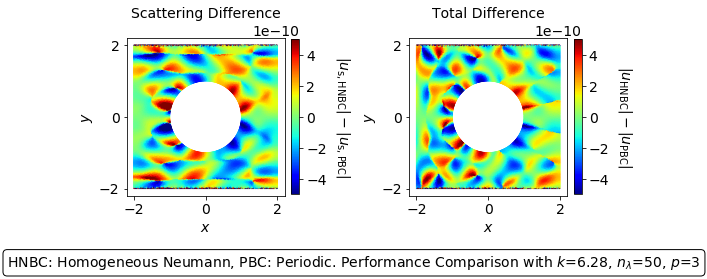

In [15]:
plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax1 = plt.subplot(1, 2, 1)
color_min =  0.5*pow(10,-9)
color_max = -0.5*pow(10,-9)
fig = plot(u_1_s_m - u_2_s_m, cmap='jet', mode='color', vmin=color_min, vmax=color_max)

plt.title('Scattering Difference', pad=20, fontsize=fsize)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=2)
colorbar = plt.colorbar(fig, fraction=0.045, pad=0.04);
colorbar.ax.get_yaxis().labelpad = 25
colorbar.ax.set_ylabel('$|u_\mathregular{s, HNBC}|-|u_\mathregular{s, PBC}|$', rotation=270, fontsize=fsize)

ax2 = plt.subplot(1, 2, 2)
color_min =  0.5*pow(10,-9)
color_max = -0.5*pow(10,-9)
fig = plot(u_1_m - u_2_m, cmap='jet', mode='color', vmin=color_min, vmax=color_max)

plt.title('Total Difference', pad=20, fontsize=fsize)
plt.xlabel(r'$x$', fontsize=fsize)
plt.ylabel(r'$y$', fontsize=fsize)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=2)
colorbar = plt.colorbar(fig, fraction=0.045, pad=0.04);
colorbar.ax.get_yaxis().labelpad = 25
colorbar.ax.set_ylabel('$|u_\mathregular{HNBC}|-|u_\mathregular{PBC}|$', rotation=270, fontsize=fsize)

plt.tight_layout()

ax2.text(-0.35,-0.45, 'HNBC: Homogeneous Neumann, PBC: Periodic. Performance Comparison with $k$=%.2f, ' %k + r'$n_{\lambda}$=%i, ' %n_lambda + r'$p$=%i' %p,
         size=12, ha="center", transform=ax2.transAxes, fontsize=fsize,
        bbox=dict(boxstyle="round", ec='black', fc='white',))

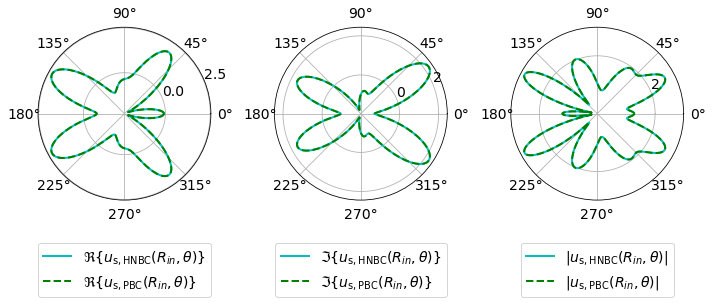

In [19]:
# Sample data (replace with your actual FEniCS results)
theta_c = np.linspace(0, 2 * np.pi, 397)
cx_in = r_1*np.cos(theta_c)
cy_in = r_1*np.sin(theta_c)
points_c = np.vstack((cx_in, cy_in)).T

# Data for Figure 1
u_1_s_r_line_c = np.array([u_1_s_r(point) for point in points_c])
u_2_s_r_line_c = np.array([u_2_s_r(point) for point in points_c])

# Data for Figure 2
u_1_s_i_line_c = np.array([u_1_s_i(point) for point in points_c])
u_2_s_i_line_c = np.array([u_2_s_i(point) for point in points_c])

# Data for Figure 3
u_1_s_m_line_c = np.array([u_1_s_m(point) for point in points_c])
u_2_s_m_line_c = np.array([u_2_s_m(point) for point in points_c])

# Create subplots for all three figures
fig, axes = plt.subplots(1, 3, subplot_kw=dict(polar=True), figsize=(10, 4))

# Legend position
leg_x = 0.5
leg_y = -0.6

# Plot Figure 1
ax1 = axes[0]
ax1.plot(theta_c, u_1_s_r_line_c, 'c', linewidth=2, label='$\Re \{ u_{\mathregular{s,HNBC}}(R_{in},\\theta) \}$')
ax1.plot(theta_c, u_2_s_r_line_c, 'g', linestyle='--', linewidth=2, label="$\Re \{ u_{\mathregular{s,PBC}}(R_{in},\\theta) \}$")
ax1.legend(loc="lower center", bbox_to_anchor=(leg_x, leg_y), fontsize=fsize)
ax1.yaxis.get_major_locator().base.set_params(nbins=2)

# Plot Figure 2
ax2 = axes[1]
ax2.plot(theta_c, u_1_s_i_line_c, 'c', linewidth=2, label='$\Im \{ u_{\mathregular{s,HNBC}}(R_{in},\\theta) \}$')
ax2.plot(theta_c, u_2_s_i_line_c, 'g', linestyle='--', linewidth=2, label="$\Im \{ u_{\mathregular{s,PBC}}(R_{in},\\theta) \}$")
ax2.legend(loc="lower center", bbox_to_anchor=(leg_x, leg_y), fontsize=fsize)
ax2.yaxis.get_major_locator().base.set_params(nbins=2)

# Plot Figure 3
ax3 = axes[2]
ax3.plot(theta_c, u_1_s_m_line_c, 'c', linewidth=2, label='$|u_{\mathregular{s,HNBC}}(R_{in},\\theta)$|')
ax3.plot(theta_c, u_2_s_m_line_c, 'g', linestyle='--', linewidth=2, label="$|u_{\mathregular{s,PBC}}(R_{in},\\theta)|$")
ax3.legend(loc="lower center", bbox_to_anchor=(leg_x, leg_y), fontsize=fsize)
ax3.yaxis.get_major_locator().base.set_params(nbins=2)

plt.tight_layout()
plt.show()

#### RESULTS

In [17]:
mf_1 = MeshFunction('size_t',mesh,mesh.topology().dim())
dx_sub_1 = Measure('dx', subdomain_data=mf_1)

# inflow unit region total
region_L_1 = AutoSubDomain(lambda x: x[0] <= xmin + 1)
region_L_1.mark(mf_1, 1)

# outflow unit region total
region_R_1 = AutoSubDomain(lambda x: x[0] >= xmax - 1)
region_R_1.mark(mf_1, 2)

In [18]:
u_1_m_T = assemble(u_1_m*dx)
u_1_m_L = assemble(u_1_m*dx_sub_1(1))
u_1_m_R = assemble(u_1_m*dx_sub_1(2))

u_2_m_T = assemble(u_2_m*dx)
u_2_m_L = assemble(u_2_m*dx_sub_1(1))
u_2_m_R = assemble(u_2_m*dx_sub_1(2))

print("")
print("Homogeneous Neumann Boundary Condition")
print("---------------------------")
print("u_1_m_T = ", u_1_m_T)
print("u_1_m_L = ", u_1_m_L)
print("u_1_m_R = ", u_1_m_R)
print("Ratio 1 = ", u_1_m_R/u_1_m_L)
print("")
print("Periodic Boundary Condition")
print("---------------------------")
print("u_2_m_T = ", u_2_m_T)
print("u_2_m_L = ", u_2_m_L)
print("u_2_m_R = ", u_2_m_R)
print("Ratio 2 = ", u_2_m_R/u_2_m_L)


Homogeneous Neumann Boundary Condition
---------------------------
u_1_m_T =  14.557922959948751
u_1_m_L =  4.9144757774922585
u_1_m_R =  3.2789192399523697
Ratio 1 =  0.6671961341165721

Periodic Boundary Condition
---------------------------
u_2_m_T =  14.557922959949117
u_2_m_L =  4.914475777492013
u_2_m_R =  3.2789192399525042
Ratio 2 =  0.6671961341166327


---
**Release Notes**

**v.1.0.0**<br>
16.09.2023<br>
Release version.<br>